In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import pickle
#import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

import h5py, ast



# Importing training data
The molecules for training are the first 100.000 extracted from ChemBL23 and saved as RDKit binary strings. The molecule objects can be fast recreated from the binary strings, while avoiding pickling the molecule objects before saving into the HDF5 file. The "info" dataset in the file contains information about the maximum length seen for the SMILES representations of the molecules as well as the characters encounted.

The dataset is a bit small, but can then be included on GitHub for illustration purposes.

In [2]:
h5f = h5py.File('data/chembl_mols_as_binstrings.h5', 'r')

In [3]:
_info = h5f['info'].value
info = ast.literal_eval(_info.decode("utf-8"))
                        
maxlen = info['maxlen']
charset = info['charset']

In [4]:
#Simple split based on position
mols = h5f['mols'][:90000]
mols_test = h5f['mols'][90000:]

# Preparing generators

The conversion from molecules to one-hot encoded arrays is handled with the molvecgen objects. It's necessary to download/clone the repository https://github.com/EBjerrum/molvecgen and run the setup script (python setup.py install)

In [5]:
from molvecgen import SmilesVectorizer
from molvecgen import HetSmilesGenerator

Two vectorizers are needed, one for the encoder input, which is padded to the left, and one to output (+ teacher forcing input) which is right padded.

In [6]:
smilesvec1 = SmilesVectorizer(canonical=False, augment=True, maxlength=maxlen, charset=charset, binary=True)
smilesvec2 = SmilesVectorizer(canonical=False, augment=True, maxlength=maxlen, charset=charset, binary=True, leftpad=False)

In [7]:
batch_size=256
train_gen = HetSmilesGenerator(mols, None, smilesvec1, smilesvec2, batch_size=batch_size, shuffle=True)
test_gen = HetSmilesGenerator(mols_test, None, smilesvec1, smilesvec2, batch_size=batch_size, shuffle=True)

<class 'molvecgen.generators.HetSmilesGenerator'>
<class 'type'>
<class 'molvecgen.generators.HetSmilesGenerator'>
<class 'type'>


In [8]:
steps_per_epoch = len(mols)//batch_size
validation_steps = len(mols_test)//batch_size

## Testing the vectorizer
A single mol is extracted from the molecules and transformed. The "pianorolls" and dimensions are plotted.

In [9]:
mol = mols[0:1]

In [10]:
i1 = smilesvec1.transform(mol)

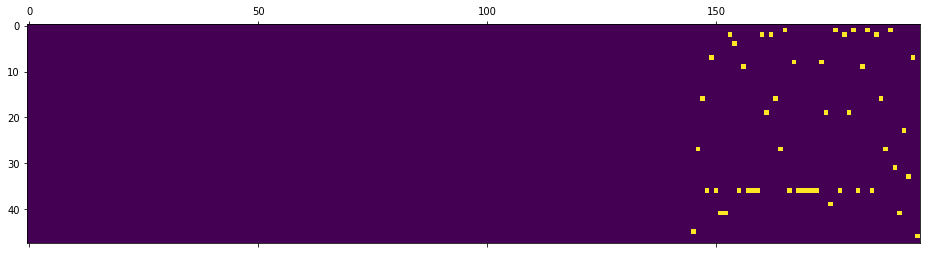

In [11]:
plt.matshow(i1[0].T)

The next function yields an augmented batch.

In [12]:
[i1, i2], o = train_gen.next()

(256, 195, 48)
(256, 194, 48)
(256, 194, 48)


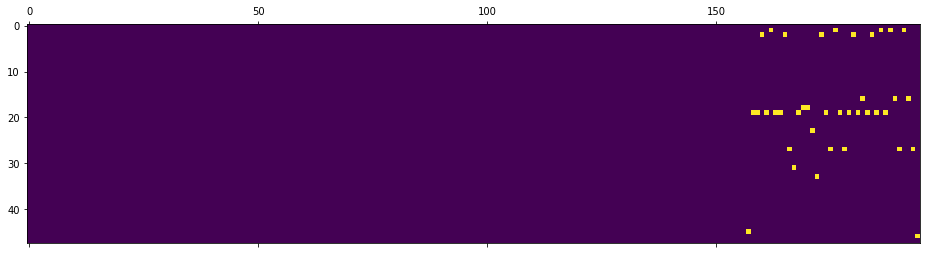

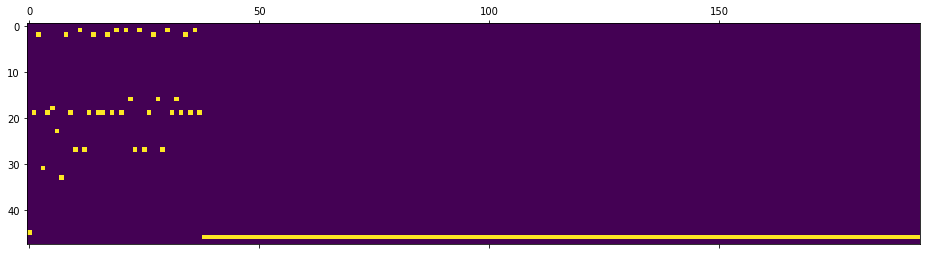

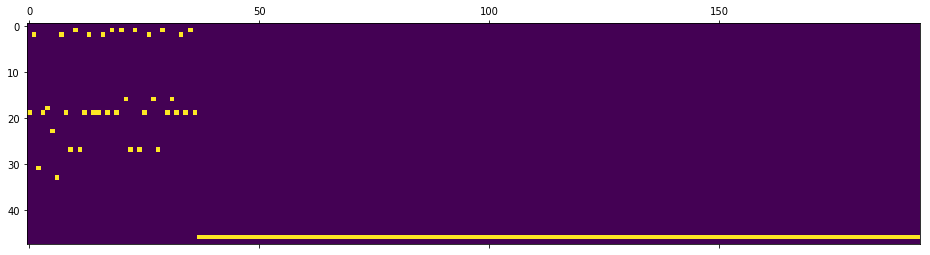

In [13]:
print(i1.shape)
plt.matshow(i1[0].T)
print(i2.shape)
plt.matshow(i2[0].T)
print(o.shape)
plt.matshow(o[0].T)

# Build neural network

In [14]:
#Grow as needed
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [15]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [16]:
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Concatenate, Dense, LSTM, Flatten, RepeatVector, TimeDistributed, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Bidirectional, GaussianNoise, BatchNormalization

#Faster drop-in for LSTM using CuDNN on TF backend on GPU
from keras.layers import CuDNNLSTM as LSTM

In [24]:
#The input encoder conv NN model

#Shapes needed for the definition of the network
input_shape = smilesvec1.dims
dec_input_shape = train_gen.dec_dims

output_len = smilesvec1.dims[0]-1
output_dims = smilesvec1.dims[-1]


lstm_dim = 256
bottleneck_dim = 128
h_activation = "relu"

bn_momentum=0.9


In [25]:
encoder_inputs = Input(shape=input_shape)
x = encoder_inputs

#The two encoder layers, number of cells are halved as Bidirectional
encoder = Bidirectional(LSTM(lstm_dim//2,
               return_sequences=True, #We return at each RNN step
               return_state=True,
               name="Encoder_LSTM"))

encoder2 = Bidirectional(LSTM(lstm_dim//2,
               return_state=True, #Return the states at end of the batch
               name="Encoder_LSTM2"))

#Get ouputs and final states of both layers
x ,state_h, state_c, state_h_reverse, state_c_reverse = encoder(x)
x = BatchNormalization(momentum=bn_momentum)(x)
encoder_outputs, state_h2, state_c2 , state_h2_reverse, state_c2_reverse = encoder2(x)

#The concatenate states
states = Concatenate(axis=-1)([state_h, state_c, state_h2, state_c2,
                              state_h_reverse, state_c_reverse, state_h2_reverse, state_c2_reverse])

states = BatchNormalization(momentum=bn_momentum)(states)

#A non-linear recombination
neck_relu = Dense(bottleneck_dim, activation=h_activation, name='bottleneck_relu')
neck_outputs = neck_relu(states)
neck_outputs = BatchNormalization(momentum=bn_momentum, name="BN_bottleneck")(neck_outputs)

#The output decoders for initial states of decoder
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
decode_h2 = Dense(lstm_dim, activation="relu")
decode_c2 = Dense(lstm_dim, activation="relu")

#The output tensors for initial states of decoder 
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
state_h_decoded2 =  decode_h2(neck_outputs)
state_c_decoded2 =  decode_c2(neck_outputs)

#Save BN layers for later reuse
state_h_decoded_BN =  BatchNormalization(momentum=bn_momentum)
state_c_decoded_BN =  BatchNormalization(momentum=bn_momentum)
state_h_decoded2_BN =  BatchNormalization(momentum=bn_momentum)
state_c_decoded2_BN =  BatchNormalization(momentum=bn_momentum)

state_h_decoded =  state_h_decoded_BN(state_h_decoded)
state_c_decoded =  state_c_decoded_BN(state_c_decoded)
state_h_decoded2 =  state_h_decoded2_BN(state_h_decoded2)
state_c_decoded2 =  state_c_decoded2_BN(state_c_decoded2)

#The initial states of the decoder
encoder_states = [state_h_decoded, state_c_decoded]
encoder_states2 = [state_h_decoded2, state_c_decoded2]

#This is the start character padded OHE smiles for teacher forcing
decoder_inputs = Input(shape=dec_input_shape)

#The Decoder LSTM layers
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    name='LSTM1_decoder'
                   )
decoder_lstm2 = LSTM(lstm_dim,
                    return_sequences=True,
                    name='LSTM2_decoder'
                   )


xo = decoder_lstm(decoder_inputs, initial_state=encoder_states)
xo = BatchNormalization(momentum=bn_momentum, name="BN_decoder")(xo)
decoder_outputs = decoder_lstm2(xo, initial_state=encoder_states2)

outputs = Dense(output_dims, activation='softmax', name="Dense_decoder")(decoder_outputs)

#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], outputs)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 195, 48)      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) [(None, 195, 256), ( 182272      input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 195, 256)     1024        bidirectional_5[0][0]            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) [(None, 256), (None, 395264      batch_normalization_13[0][0]     
__________________________________________________________________________________________________
concatenat

In [26]:
#Load model
#from keras.models import load_model
#name = "models/enum2enum_smi2smi_val_loss_0.1950"
#model = load_model("%s_full.h5"%name)

# Train Network

In [27]:
#Compile model
#from tensorflow.python.keras.optimizers import RMSprop, Adam
from keras.optimizers import RMSprop, Adam

lr=0.0005
opt=Adam(lr=lr) #Default 0.001
model.compile(loss="categorical_crossentropy", optimizer=opt)

In [28]:
#from tensorflow.python.keras.callbacks import History, ReduceLROnPlateau
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=1e-6, verbose=1, epsilon=1e-5)

In [29]:
model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=50,
                              validation_data=test_gen,
                              validation_steps=validation_steps,
                              callbacks=[rlr, h]
                             )

Epoch 1/50
351/351 [==============================] - 210s 598ms/step - loss: 0.4587 - val_loss: 0.3627
Epoch 2/50
351/351 [==============================] - 202s 577ms/step - loss: 0.2557 - val_loss: 0.3108
Epoch 3/50
351/351 [==============================] - 203s 577ms/step - loss: 0.2186 - val_loss: 0.2656
Epoch 4/50
351/351 [==============================] - 202s 576ms/step - loss: 0.1970 - val_loss: 0.8414
Epoch 5/50
351/351 [==============================] - 202s 575ms/step - loss: 0.1826 - val_loss: 0.2730
Epoch 6/50
351/351 [==============================] - 202s 574ms/step - loss: 0.1709 - val_loss: 0.2788
Epoch 7/50
351/351 [==============================] - 202s 575ms/step - loss: 0.1616 - val_loss: 0.2985
Epoch 8/50
351/351 [==============================] - 202s 576ms/step - loss: 0.1549 - val_loss: 0.3492

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/50
351/351 [==============================] - 202s 576ms/step - loss: 0.1464 - 

KeyboardInterrupt: 

# Save network components

In [30]:
#Basename for saving and save full model
name="models/enum2enum_val_loss_%0.4F"%np.mean(h.history['val_loss'][-10:])
print(name)
model.save("%s_full.h5"%name)

models/enum2enum_val_loss_0.1885


/home/kfxl284/miniconda3/envs/keras2/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer LSTM1_decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'batch_normalization_15/cond/Merge:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'batch_normalization_16/cond/Merge:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/kfxl284/miniconda3/envs/keras2/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer LSTM2_decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'batch_normalization_17/cond/Merge:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'batch_normalization_18/cond/Merge:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [31]:
#Save history
pickle.dump( h.history, open( "%s_trainhist.pickle"%name, "wb" ) )

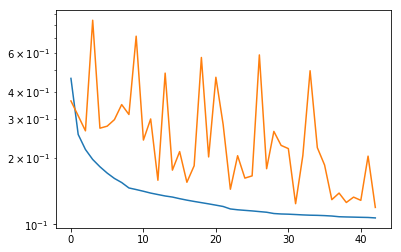

In [32]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.yscale('log')
plt.savefig("%s_history_plot.png"%name)


In [33]:
#Save each part of the model
#Encoder (Easy)
mol_to_latent_model = Model(encoder_inputs, neck_outputs)
mol_to_latent_model.save("%s_mol2lat.h5"%name)
mol_to_latent_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 195, 48)      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) [(None, 195, 256), ( 182272      input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 195, 256)     1024        bidirectional_5[0][0]            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) [(None, 256), (None, 395264      batch_normalization_13[0][0]     
__________________________________________________________________________________________________
concatenat

In [34]:
#Decoder (teacher enforcing): Part 1 lat to states
#Why is leaky relu 128, is it only the activation function so, the one before should be dense with activation=linear??
latent_input = Input(shape=(bottleneck_dim,))
#reuse_layers
state_h_decoded_save =  decode_h(latent_input)
state_c_decoded_save =  decode_c(latent_input)
state_h_decoded_save_2 =  decode_h2(latent_input)
state_c_decoded_save_2 =  decode_c2(latent_input)

#Reuse BN layers
state_h_decoded_save =  state_h_decoded_BN(state_h_decoded_save)
state_c_decoded_save =  state_c_decoded_BN(state_c_decoded_save)
state_h_decoded_save_2 =  state_h_decoded2_BN(state_h_decoded_save_2)
state_c_decoded_save_2 =  state_c_decoded2_BN(state_c_decoded_save_2)

#Define model and save
latent_to_states_model = Model(latent_input, [state_h_decoded_save, state_c_decoded_save, state_h_decoded_save_2, state_c_decoded_save_2])
latent_to_states_model.save("%s_lat2stat.h5"%name)
latent_to_states_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 256)          33024       input_7[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          33024       input_7[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          33024       input_7[0][0]                    
__________________________________________________________________________________________________
dense_12 (

In [35]:
#Decoder; stateful, This must match definition in full model
#This is the start character padded OHE smiles
inf_decoder_inputs = Input(batch_shape=(1,1, dec_input_shape[-1]))


inf_decoder_lstm = LSTM(lstm_dim,
                        return_sequences=True,
                        name='LSTM1_decoder',
                        stateful=True,
                       )
inf_decoder_lstm2 = LSTM(lstm_dim,
                        return_sequences=True,
                        name='LSTM2_decoder',
                        stateful=True,
                       )

#Initial states will be set before decoding
xo = inf_decoder_lstm(inf_decoder_inputs)
xo = BatchNormalization(name="BN_decoder")(xo)

inf_decoder_outputs = inf_decoder_lstm2(xo)

inf_outputs = Dense(output_dims, activation='softmax', name="Dense_decoder")(inf_decoder_outputs)

sample_model = Model(inf_decoder_inputs, inf_outputs)
sample_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (1, 1, 48)                0         
_________________________________________________________________
LSTM1_decoder (CuDNNLSTM)    (1, 1, 256)               313344    
_________________________________________________________________
BN_decoder (BatchNormalizati (1, 1, 256)               1024      
_________________________________________________________________
LSTM2_decoder (CuDNNLSTM)    (1, 1, 256)               526336    
_________________________________________________________________
Dense_decoder (Dense)        (1, 1, 48)                12336     
Total params: 853,040
Trainable params: 852,528
Non-trainable params: 512
_________________________________________________________________


In [36]:
#Copy the layers weight to the new non-batch architecture
for layername in  ["LSTM1_decoder", "LSTM2_decoder", "Dense_decoder", "BN_decoder"]:
    sample_model.get_layer(layername).set_weights(model.get_layer(layername).get_weights())

In [37]:
sample_model.save("%s_sample_model.h5"%name)

In [38]:
!ls -ltr models

total 148864
-rw-rw---- 1 kfxl284 xem-scp-cc 20549632 Dec 11 09:39 enum2enum_val_loss_NAN_full.h5
-rw-rw---- 1 kfxl284 xem-scp-cc      252 Dec 11 09:39 enum2enum_val_loss_NAN_trainhist.pickle
-rw-rw---- 1 kfxl284 xem-scp-cc     4811 Dec 11 09:39 enum2enum_val_loss_NAN_history_plot.png
-rw-rw---- 1 kfxl284 xem-scp-cc  2895864 Dec 11 09:40 enum2enum_val_loss_NAN_mol2lat.h5
-rw-rw---- 1 kfxl284 xem-scp-cc 20535064 Dec 11 09:45 enum2enum_val_loss_5.8825_full.h5
-rw-rw---- 1 kfxl284 xem-scp-cc 20535064 Dec 11 09:45 enum2enum_val_loss_5.2043_full.h5
-rw-rw---- 1 kfxl284 xem-scp-cc      317 Dec 11 09:45 enum2enum_val_loss_5.2043_trainhist.pickle
-rw-rw---- 1 kfxl284 xem-scp-cc     6175 Dec 11 09:45 enum2enum_val_loss_5.2043_history_plot.png
-rw-rw---- 1 kfxl284 xem-scp-cc  2895880 Dec 11 09:45 enum2enum_val_loss_5.2043_mol2lat.h5
-rw-rw---- 1 kfxl284 xem-scp-cc  3433112 Dec 11 09:49 enum2enum_val_loss_5.2043_sample_model.h5
-rw-rw---- 1 kfxl284 xem-scp-cc   574600 Dec 11 09:50 enum2enum_val_l